# VWAP-Based Trading Strategy Report

---

## 1. Data Overview and Preprocessing

The analysis uses two primary datasets: **Order Book Updates** (quotes) and **Trades**.

* **Order Book Updates (Quotes):** 323,759 records. These are used to calculate liquidity, spread, and price imbalance.
* **Trades:** 6,127 records. These are used for calculating the **Volume-Weighted Average Price (VWAP)** and for backtesting the strategy.

Key features derived from the data include:

* **Mid-Price & Spread:** Simple mid-price and spread in basis points (bps).
* **Weighted Mid-Price:** A more robust mid-price using the top three levels of the order book.
* **Order Book Imbalance:** Calculated as $(\text{Bid Liquidity} - \text{Ask Liquidity}) / (\text{Bid Liquidity} + \text{Ask Liquidity})$. This indicates buy pressure (positive imbalance) or sell pressure (negative imbalance).
* **VWAP:** Both a **cumulative** VWAP and **rolling 5-minute/1-minute** VWAPs are calculated.

---

## 2. Signal Generation

The trading signal is designed to identify short-term mean-reversion opportunities by comparing the current **mid-price** to the **5-minute Rolling VWAP** and incorporating the **Order Book Imbalance** as a confirmation filter. The deviation is measured in basis points (bps).

The `generate_signals` function defines the following logic based on a **threshold** of $\mathbf{2 \text{ bps}}$ for deviation:

| Signal | Deviation from 5-min VWAP | Order Book Imbalance | Interpretation |
| :--- | :--- | :--- | :--- |
| **STRONG BUY** | $\text{Deviation} < -2 \text{ bps}$ | $\text{Imbalance} > 0.5$ | Price is significantly below VWAP, and there is strong **bid pressure** (buy side liquidity). |
| **BUY** | $\text{Deviation} < -2 \text{ bps}$ | $\text{Imbalance} \le 0.5$ | Price is significantly below VWAP. |
| **STRONG SELL** | $\text{Deviation} > 2 \text{ bps}$ | $\text{Imbalance} < -0.5$ | Price is significantly above VWAP, and there is strong **ask pressure** (sell side liquidity). |
| **SELL** | $\text{Deviation} > 2 \text{ bps}$ | $\text{Imbalance} \ge -0.5$ | Price is significantly above VWAP. |
| **NEUTRAL** | $-2 \text{ bps} \le \text{Deviation} \le 2 \text{ bps}$ | Any | Price is close to VWAP. |

The signal distribution shows the strategy is **mostly NEUTRAL (66.2%)**. **BUY** and **SELL** signals account for $17.5\%$ and $16.0\%$ respectively, while **STRONG** signals are rare ($0.1\%$ each).

**Aggressive signals** are also generated using a smaller **1-minute VWAP window** and a lower **threshold of $\mathbf{1.5 \text{ bps}}$**.

---

## 3. Maker Strategy Logic

The strategy is a **market making** approach that attempts to capture the bid-ask spread. It focuses only on the **STRONG BUY (signal = 1)** and **STRONG SELL (signal = -1)** signals for entry.

### Signal-Based Order Placement

The strategy places limit orders only when the current **inventory is zero** and a **strong signal** is present:

* **Strong Buy (Signal = 1):** Places a limit buy order at the **Best Bid**.
* **Strong Sell (Signal = -1):** Places a limit sell order at the **Best Ask**.

### Fill Condition and Inventory Management

* **Fill Condition:** A limit order (placed at the B1/A1) is considered filled when the next trade's **market price** moves **below or equals** (for Buy) or **above or equals** (for Sell) the order's limit price.
* **Inventory Control:** The maximum allowed inventory is $10$ units (though the backtest results suggest a practical $1$ contract limit was adhered to).
* **Liquidation Priority:** If the inventory is non-zero, the strategy's primary goal is to close the position to zero before entering a new position based on a signal.
    * **Long Inventory (Inventory > 0):** Places a sell limit order at the **Best Ask**.
    * **Short Inventory (Inventory < 0):** Places a buy limit order at the **Best Bid**.
* **Maker Fee:** The strategy assumes a maker fee of $0 \text{ bps}$ (implying a $\text{FEE\_RATE} = 0$).

---

## 4. Backtest Results

The backtest of the Maker Strategy produced the following results:

* **Total Fills:** 6 trades.
* **Final Inventory:** 0.
* **Total PnL:** $\mathbf{\$0.04}$.
* **Final Cash (Realized PnL):** $\mathbf{\$0.04}$.
* **Unrealized PnL (Inventory Value):** $\mathbf{\$0.00}$ (since the final inventory is 0).

The small number of fills (6 trades) suggests the strict entry criteria ($\text{Deviation} > 2 \text{ bps}$ and $|\text{Imbalance}| > 0.5$) for the strong signals led to very few trade entries. The positive PnL of $\$0.04$ indicates that the 6 executed trades were profitable overall. 

Data Overview

Order Book Updates: 323759 records
Trades: 6127 records

Time Range:
  Quotes: 2020-02-12 13:32:17.983467008 to 2020-02-12 21:59:27.000688128
  Trades: 2020-02-12 13:50:47.837733120 to 2020-02-12 21:12:35.950408960
VWAP Statistics:

Price Statistics:
  Min Price: $336.44
  Max Price: $337.63
  Mean Price: $337.05
  Final VWAP: $337.05

Deviation Statistics (5-min VWAP):
  Mean Deviation: 0.00 bps
  Std Deviation: 2.38 bps
  Min Deviation: -11.91 bps
  Max Deviation: 9.23 bps

Spread Statistics:
  Mean Spread: 1.32 bps
  Min Spread: 0.30 bps
  Max Spread: 1193.79 bps

Signal Distribution:
  NEUTRAL: 4059 (66.2%)
  BUY: 1074 (17.5%)
  SELL: 982 (16.0%)
  STRONG_SELL: 6 (0.1%)
  STRONG_BUY: 6 (0.1%)

Order Book Imbalance:
  Mean Imbalance: -0.0037
  Positive Imbalance: 133650 (41.3%)
Signal Performance Metrics
            deviation_vwap_5min       imbalance spread_bps    SIZE
                           mean   std      mean       mean     sum
signal                          

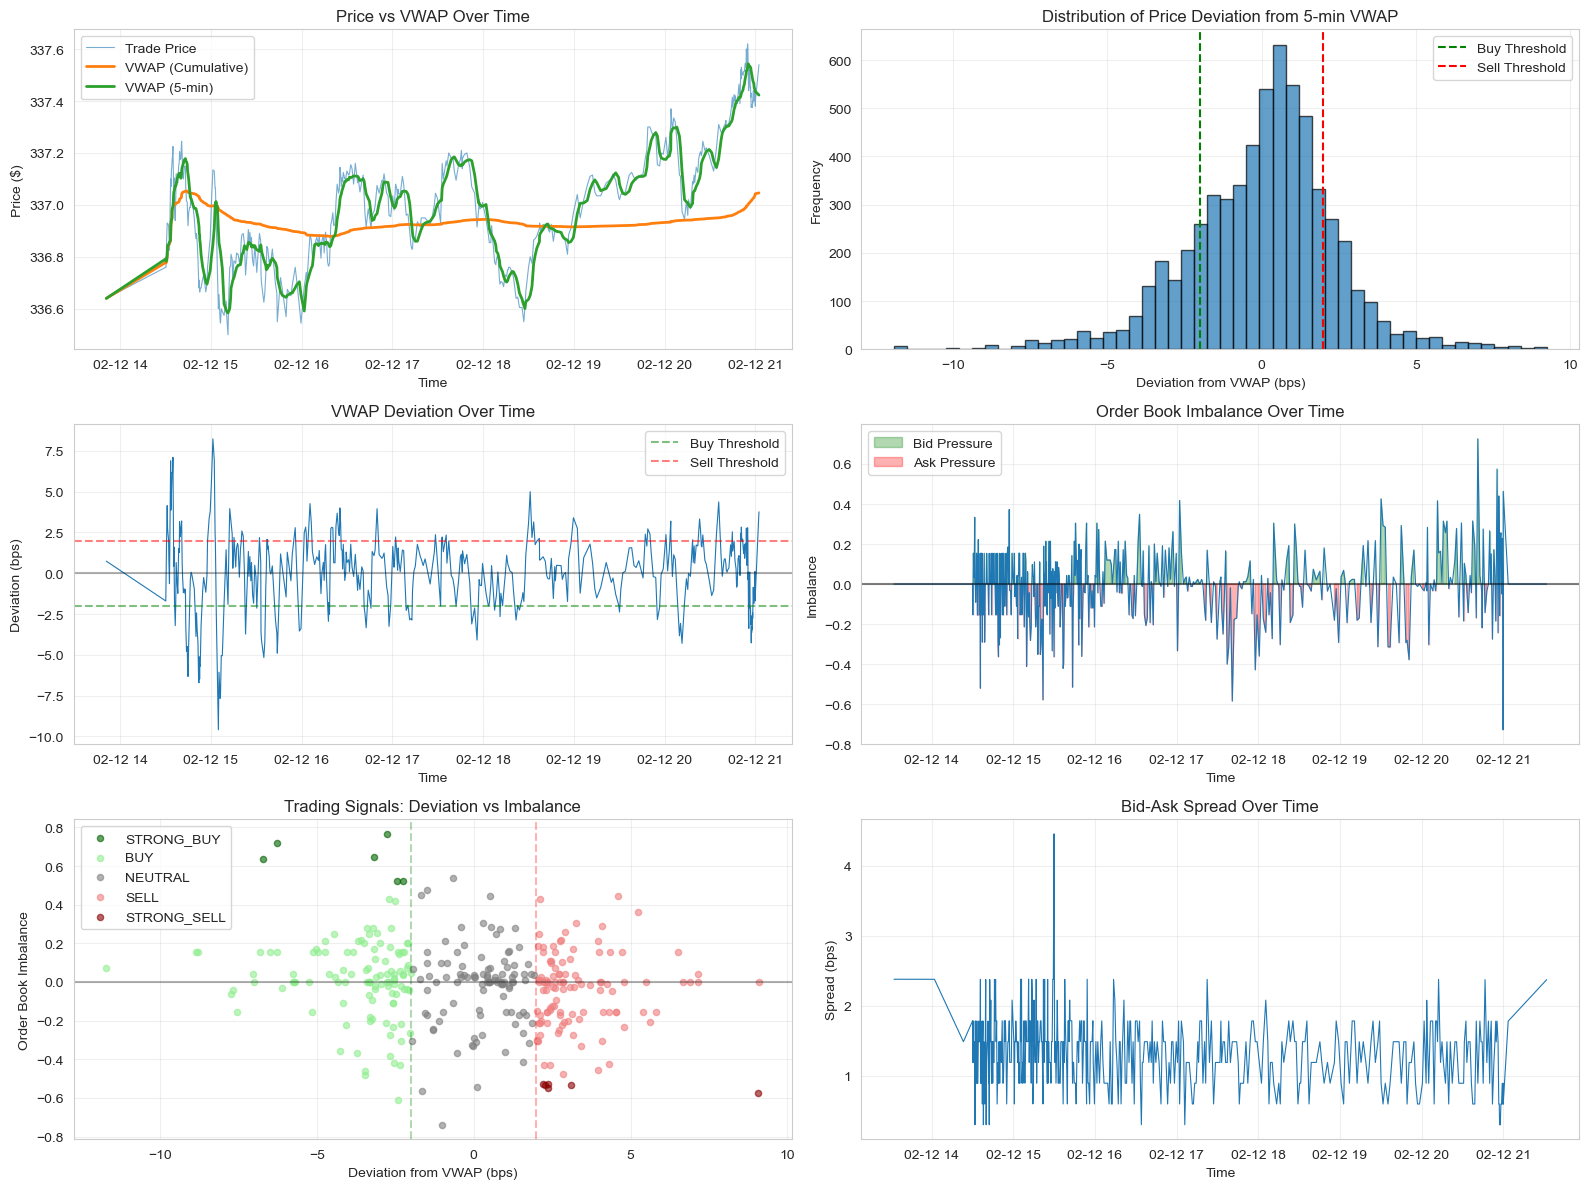

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Load the data
df_quotes = pd.read_csv('20200212_book_updates.csv.gz')
df_trades = pd.read_csv('20200212_trades.csv.gz')

# Convert timestamps to datetime
df_quotes['COLLECTION_TIME'] = pd.to_datetime(df_quotes['COLLECTION_TIME'])
df_trades['COLLECTION_TIME'] = pd.to_datetime(df_trades['COLLECTION_TIME'])


print("Data Overview")

print(f"\nOrder Book Updates: {len(df_quotes)} records")
print(f"Trades: {len(df_trades)} records")
print(f"\nTime Range:")
print(f"  Quotes: {df_quotes['COLLECTION_TIME'].min()} to {df_quotes['COLLECTION_TIME'].max()}")
print(f"  Trades: {df_trades['COLLECTION_TIME'].min()} to {df_trades['COLLECTION_TIME'].max()}")


df_quotes['mid_price'] = (df_quotes['BID_PRICE_1'] + df_quotes['ASK_PRICE_1']) / 2
df_quotes['spread'] = df_quotes['ASK_PRICE_1'] - df_quotes['BID_PRICE_1']
df_quotes['spread_bps'] = (df_quotes['spread'] / df_quotes['mid_price']) * 10000

# Weighted mid price (using top 3 levels)
df_quotes['weighted_mid'] = (
    (df_quotes['BID_PRICE_1'] * df_quotes['BID_SIZE_1'] + 
     df_quotes['BID_PRICE_2'] * df_quotes['BID_SIZE_2'] + 
     df_quotes['BID_PRICE_3'] * df_quotes['BID_SIZE_3'] +
     df_quotes['ASK_PRICE_1'] * df_quotes['ASK_SIZE_1'] + 
     df_quotes['ASK_PRICE_2'] * df_quotes['ASK_SIZE_2'] + 
     df_quotes['ASK_PRICE_3'] * df_quotes['ASK_SIZE_3']) /
    (df_quotes['BID_SIZE_1'] + df_quotes['BID_SIZE_2'] + df_quotes['BID_SIZE_3'] +
     df_quotes['ASK_SIZE_1'] + df_quotes['ASK_SIZE_2'] + df_quotes['ASK_SIZE_3'])
)

# Order book imbalance
df_quotes['bid_liquidity'] = df_quotes['BID_SIZE_1'] + df_quotes['BID_SIZE_2'] + df_quotes['BID_SIZE_3']
df_quotes['ask_liquidity'] = df_quotes['ASK_SIZE_1'] + df_quotes['ASK_SIZE_2'] + df_quotes['ASK_SIZE_3']
df_quotes['imbalance'] = (df_quotes['bid_liquidity'] - df_quotes['ask_liquidity']) / (df_quotes['bid_liquidity'] + df_quotes['ask_liquidity'])


# Standard VWAP (cumulative from start)
df_trades['cumulative_volume'] = df_trades['SIZE'].cumsum()
df_trades['cumulative_pv'] = (df_trades['PRICE'] * df_trades['SIZE']).cumsum()
df_trades['vwap'] = df_trades['cumulative_pv'] / df_trades['cumulative_volume']

# Rolling VWAP (5-minute window)
def calculate_rolling_vwap(df, window_minutes=5):
    
    df = df.sort_values('COLLECTION_TIME').copy()
    vwap_list = []
    
    for idx, row in df.iterrows():
        current_time = row['COLLECTION_TIME']
        window_start = current_time - timedelta(minutes=window_minutes)
        
        window_trades = df[(df['COLLECTION_TIME'] >= window_start) & 
                          (df['COLLECTION_TIME'] <= current_time)]
        
        if len(window_trades) > 0:
            total_pv = (window_trades['PRICE'] * window_trades['SIZE']).sum()
            total_volume = window_trades['SIZE'].sum()
            vwap_list.append(total_pv / total_volume if total_volume > 0 else row['PRICE'])
        else:
            vwap_list.append(row['PRICE'])
    
    return vwap_list

df_trades['vwap_5min'] = calculate_rolling_vwap(df_trades, window_minutes=5)
df_trades['vwap_1min'] = calculate_rolling_vwap(df_trades, window_minutes=1)



# Merge trades with nearest quote (forward fill)
df_merged = pd.merge_asof(
    df_trades.sort_values('COLLECTION_TIME'),
    df_quotes[['COLLECTION_TIME', 'mid_price', 'weighted_mid', 'spread_bps', 'imbalance', 'BID_PRICE_1', 'ASK_PRICE_1']].sort_values('COLLECTION_TIME'),
    on='COLLECTION_TIME',
    direction='backward'
)

# Calculate deviations in basis points
df_merged['deviation_vwap'] = ((df_merged['mid_price'] - df_merged['vwap']) / df_merged['vwap']) * 10000
df_merged['deviation_vwap_5min'] = ((df_merged['mid_price'] - df_merged['vwap_5min']) / df_merged['vwap_5min']) * 10000
df_merged['deviation_vwap_1min'] = ((df_merged['mid_price'] - df_merged['vwap_1min']) / df_merged['vwap_1min']) * 10000

# Price momentum
df_merged['price_change'] = df_merged['PRICE'].diff()
df_merged['price_change_pct'] = df_merged['PRICE'].pct_change() * 100


# generate signals for lookup


def generate_signals(df, deviation_col='deviation_vwap_5min', threshold=2):
    
    signals = []
    
    for idx, row in df.iterrows():
        deviation = row[deviation_col]
        imbalance = row['imbalance']
        spread = row['spread_bps']
        
        # Signal logic
        if deviation < -threshold and imbalance > 0.5:  # Price below VWAP, bid pressure
            signal = 'STRONG_BUY'
        elif deviation < -threshold:
            signal = 'BUY'
        elif deviation > threshold and imbalance < -0.5:  # Price above VWAP, ask pressure
            signal = 'STRONG_SELL'
        elif deviation > threshold:
            signal = 'SELL'
        else:
            signal = 'NEUTRAL'
        
        signals.append(signal)
    
    return signals

df_merged['signal'] = generate_signals(df_merged, 'deviation_vwap_5min', threshold=2)
df_merged['signal_aggressive'] = generate_signals(df_merged, 'deviation_vwap_1min', threshold=1.5)


# Statistic



print("VWAP Statistics:")


print(f"\nPrice Statistics:")
print(f"  Min Price: ${df_trades['PRICE'].min():.2f}")
print(f"  Max Price: ${df_trades['PRICE'].max():.2f}")
print(f"  Mean Price: ${df_trades['PRICE'].mean():.2f}")
print(f"  Final VWAP: ${df_trades['vwap'].iloc[-1]:.2f}")

print(f"\nDeviation Statistics (5-min VWAP):")
print(f"  Mean Deviation: {df_merged['deviation_vwap_5min'].mean():.2f} bps")
print(f"  Std Deviation: {df_merged['deviation_vwap_5min'].std():.2f} bps")
print(f"  Min Deviation: {df_merged['deviation_vwap_5min'].min():.2f} bps")
print(f"  Max Deviation: {df_merged['deviation_vwap_5min'].max():.2f} bps")

print(f"\nSpread Statistics:")
print(f"  Mean Spread: {df_quotes['spread_bps'].mean():.2f} bps")
print(f"  Min Spread: {df_quotes['spread_bps'].min():.2f} bps")
print(f"  Max Spread: {df_quotes['spread_bps'].max():.2f} bps")

print(f"\nSignal Distribution:")
signal_counts = df_merged['signal'].value_counts()
for signal, count in signal_counts.items():
    print(f"  {signal}: {count} ({count/len(df_merged)*100:.1f}%)")

print(f"\nOrder Book Imbalance:")
print(f"  Mean Imbalance: {df_quotes['imbalance'].mean():.4f}")
print(f"  Positive Imbalance: {(df_quotes['imbalance'] > 0).sum()} ({(df_quotes['imbalance'] > 0).sum()/len(df_quotes)*100:.1f}%)")


# Visulization

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Price vs VWAP over time
ax1 = axes[0, 0]
sample_trades = df_merged.iloc[::max(1, len(df_merged)//500)]  # Sample for clarity
ax1.plot(sample_trades['COLLECTION_TIME'], sample_trades['PRICE'], label='Trade Price', alpha=0.6, linewidth=0.8)
ax1.plot(sample_trades['COLLECTION_TIME'], sample_trades['vwap'], label='VWAP (Cumulative)', linewidth=2)
ax1.plot(sample_trades['COLLECTION_TIME'], sample_trades['vwap_5min'], label='VWAP (5-min)', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Price ($)')
ax1.set_title('Price vs VWAP Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Deviation distribution
ax2 = axes[0, 1]
ax2.hist(df_merged['deviation_vwap_5min'].dropna(), bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=-2, color='g', linestyle='--', label='Buy Threshold')
ax2.axvline(x=2, color='r', linestyle='--', label='Sell Threshold')
ax2.set_xlabel('Deviation from VWAP (bps)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Price Deviation from 5-min VWAP')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Deviation over time
ax3 = axes[1, 0]
ax3.plot(sample_trades['COLLECTION_TIME'], sample_trades['deviation_vwap_5min'], linewidth=0.8)
ax3.axhline(y=-2, color='g', linestyle='--', alpha=0.5, label='Buy Threshold')
ax3.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='Sell Threshold')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.set_xlabel('Time')
ax3.set_ylabel('Deviation (bps)')
ax3.set_title('VWAP Deviation Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Order book imbalance
ax4 = axes[1, 1]
sample_quotes = df_quotes.iloc[::max(1, len(df_quotes)//500)]
ax4.plot(sample_quotes['COLLECTION_TIME'], sample_quotes['imbalance'], linewidth=0.8)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.fill_between(sample_quotes['COLLECTION_TIME'], sample_quotes['imbalance'], 0, 
                  where=(sample_quotes['imbalance'] > 0), alpha=0.3, color='green', label='Bid Pressure')
ax4.fill_between(sample_quotes['COLLECTION_TIME'], sample_quotes['imbalance'], 0, 
                  where=(sample_quotes['imbalance'] < 0), alpha=0.3, color='red', label='Ask Pressure')
ax4.set_xlabel('Time')
ax4.set_ylabel('Imbalance')
ax4.set_title('Order Book Imbalance Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Signal scatter plot
ax5 = axes[2, 0]
for signal, color in [('STRONG_BUY', 'darkgreen'), ('BUY', 'lightgreen'), 
                      ('NEUTRAL', 'gray'), ('SELL', 'lightcoral'), ('STRONG_SELL', 'darkred')]:
    mask = df_merged['signal'] == signal
    if mask.sum() > 0:
        sample = df_merged[mask].iloc[::max(1, mask.sum()//100)]
        ax5.scatter(sample['deviation_vwap_5min'], sample['imbalance'], 
                   c=color, label=signal, alpha=0.6, s=20)
ax5.axvline(x=-2, color='g', linestyle='--', alpha=0.3)
ax5.axvline(x=2, color='r', linestyle='--', alpha=0.3)
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax5.set_xlabel('Deviation from VWAP (bps)')
ax5.set_ylabel('Order Book Imbalance')
ax5.set_title('Trading Signals: Deviation vs Imbalance')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Spread over time
ax6 = axes[2, 1]
ax6.plot(sample_quotes['COLLECTION_TIME'], sample_quotes['spread_bps'], linewidth=0.8)
ax6.set_xlabel('Time')
ax6.set_ylabel('Spread (bps)')
ax6.set_title('Bid-Ask Spread Over Time')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vwap_analysis.png', dpi=300, bbox_inches='tight')


# Save signals to CSV
output_df = df_merged[['COLLECTION_TIME', 'PRICE', 'SIZE', 'vwap', 'vwap_5min', 
                        'mid_price', 'deviation_vwap_5min', 'imbalance', 
                        'spread_bps', 'signal', 'signal_aggressive']]
output_df.to_csv('vwap_trading_signals.csv', index=False)

# Summary statistics by signal

print("Signal Performance Metrics")
summary = df_merged.groupby('signal').agg({
    'deviation_vwap_5min': ['mean', 'std'],
    'imbalance': 'mean',
    'spread_bps': 'mean',
    'SIZE': 'sum'
}).round(2)
print(summary)

Strategy Result
Total Fills: 6
Final Inventory: 0
Final Cash (Realized PnL portion + Fees): $0.04
Unrealized PnL (Inventory Value): $0.00 (based on $337.52)
Total PnL: $0.04


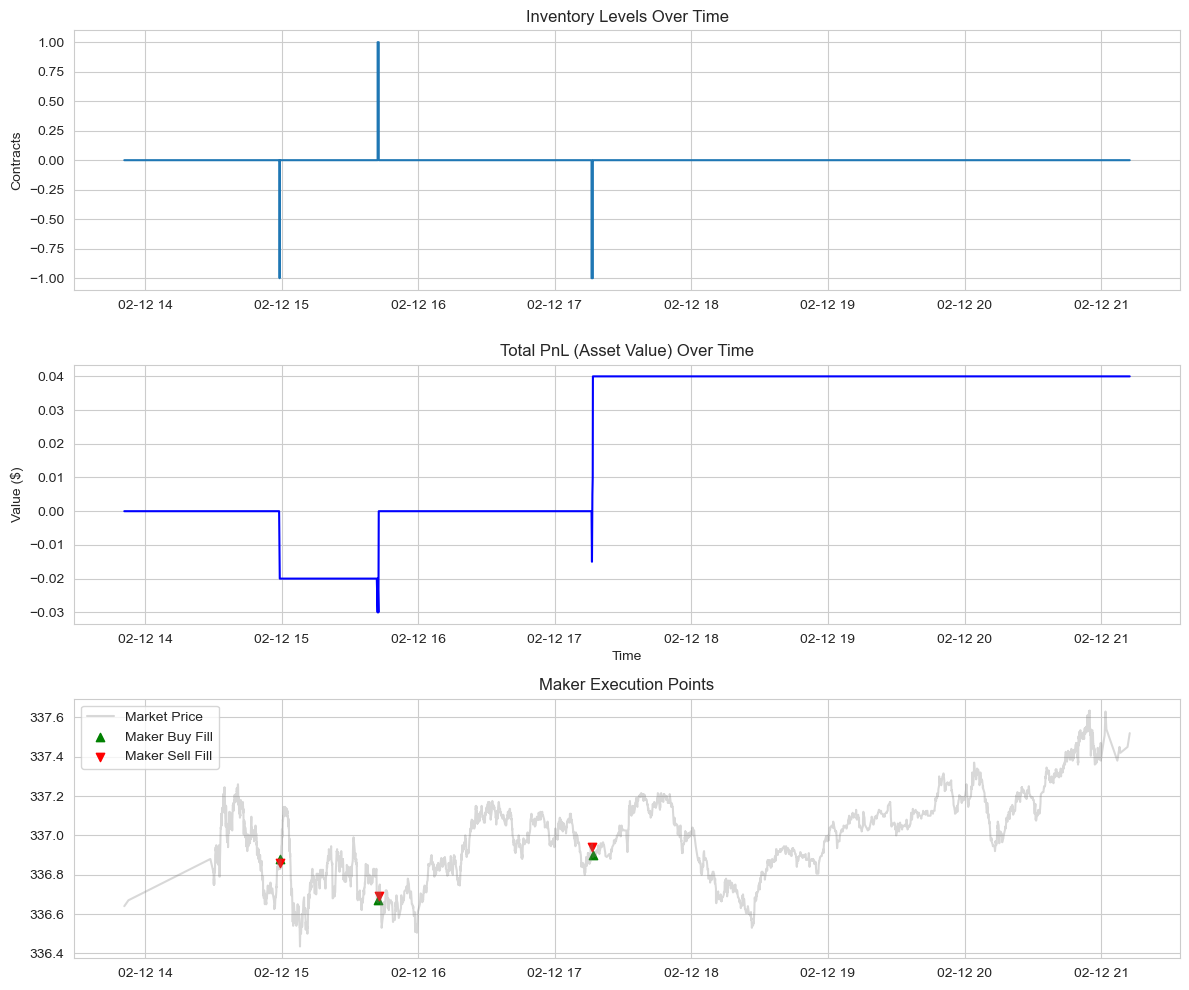


Last 5 Trades:
                           Time       Type   Price  Volume  Fee  \
1 2020-02-12 14:59:05.542285056   Fill_Buy  336.88       1  0.0   
2 2020-02-12 15:42:06.623034880   Fill_Buy  336.67       1  0.0   
3 2020-02-12 15:42:36.478145024  Fill_Sell  336.69       1  0.0   
4 2020-02-12 17:16:06.719497984  Fill_Sell  336.94       1  0.0   
5 2020-02-12 17:16:41.649118976   Fill_Buy  336.90       1  0.0   

   Inventory_After  
1                0  
2                1  
3                0  
4               -1  
5                0  


In [3]:
# The Maker Strategy Backtest


# Signal generation 


if 'vwap_5min' in df_merged.columns:
    df_merged['deviation'] = ((df_merged['PRICE'] - df_merged['vwap_5min']) / df_merged['vwap_5min']) * 10000
    
    ENTRY_DEV = 2.0
    ENTRY_IMB = 0.5
    
    df_merged['raw_signal'] = 0
    # Strong Buy -> Place limit order at Bid (Signal = 1)
    df_merged.loc[(df_merged['deviation'] < -ENTRY_DEV) & (df_merged['imbalance'] > ENTRY_IMB), 'raw_signal'] = 1
    # Strong Sell -> Place limit order at Ask (Signal = -1)
    df_merged.loc[(df_merged['deviation'] > ENTRY_DEV) & (df_merged['imbalance'] < -ENTRY_IMB), 'raw_signal'] = -1
    
    # Shift 1 to prevent look-ahead bias (Decision at T based on T-1 info)
    df_merged['maker_signal'] = df_merged['raw_signal'].shift(1).fillna(0)
    
    

# Maker Strategy Backtest

# Parameters setup
MAX_INVENTORY = 10          # Maximum inventory unit
MAKER_FEE_BPS = 0           # Assuming 0 bps fee for neutrality, adjust based on actual exchange rate
STOP_LOSS_PRICE_DIST = 100  # Unused in current logic, kept for structure
FEE_RATE = MAKER_FEE_BPS / 10000 

# State variables
inventory = 0
cash = 0.0
trades_log = []
pnl_history = []
active_buy_order_price = None 
active_sell_order_price = None

# Convert to Numpy for speed
times = df_merged['COLLECTION_TIME'].values
prices = df_merged['PRICE'].values         
best_bids = df_merged['BID_PRICE_1'].values 
best_asks = df_merged['ASK_PRICE_1'].values
signals = df_merged['maker_signal'].values


for i in range(len(df_merged)):
    current_time = times[i]
    market_price = prices[i] # Latest executed trade price
    current_bid = best_bids[i]
    current_ask = best_asks[i]
    signal = signals[i]
    
    # Check for Fills
    # Use Trade Price to determine if limit order at B1/A1 was filled.
    
    # Check Buy Order (placed at Bid)
    if active_buy_order_price is not None:
        limit_price = active_buy_order_price
        
        # Fill condition: If current Trade Price moves below or equals our limit price
        if market_price <= limit_price: 
            
            # Maker Buy Fill: Cost deducted by Fee (Negative FEE_RATE becomes revenue)
            cost_with_fee = limit_price * (1 + FEE_RATE) 
            
            inventory += 1
            cash -= cost_with_fee
            
            trades_log.append({
                'Time': current_time,
                'Type': 'Fill_Buy',
                'Price': limit_price,
                'Volume': 1,
                'Fee': limit_price * FEE_RATE, # Negative indicates rebate
                'Inventory_After': inventory
            })
            active_buy_order_price = None 

    # Check Sell Order (placed at Ask)
    if active_sell_order_price is not None:
        limit_price = active_sell_order_price
        
        # Fill condition: If current Trade Price moves above or equals our limit price
        if market_price >= limit_price:
            
            # Maker Sell Fill: Revenue added by Fee (Negative FEE_RATE becomes revenue)
            revenue_with_fee = limit_price * (1 - FEE_RATE) 
            
            inventory -= 1
            cash += revenue_with_fee
            
            trades_log.append({
                'Time': current_time,
                'Type': 'Fill_Sell',
                'Price': limit_price,
                'Volume': 1,
                'Fee': limit_price * FEE_RATE, # Negative indicates rebate
                'Inventory_After': inventory
            })
            active_sell_order_price = None 

    # Strategy Update Quotes 
    
    # Cancel-Replace (Clear old orders)
    active_buy_order_price = None
    active_sell_order_price = None
    
    can_buy = inventory < MAX_INVENTORY
    can_sell = inventory > -MAX_INVENTORY
    
    
    # Inventory Management: Liquidation priority
    if inventory > 0 and can_sell:
        # Long inventory, place sell limit order to close (at Best Ask)
        active_sell_order_price = current_ask
        
    elif inventory < 0 and can_buy:
        # Short inventory, place buy limit order to close (at Best Bid)
        active_buy_order_price = current_bid
        
    # Signal Entry (Only if inventory is 0 and signal is active)
    elif inventory == 0:
        if signal == 1 and can_buy:
            # Strong Buy signal: Place order at Best Bid
            active_buy_order_price = current_bid
            
        elif signal == -1 and can_sell:
            # Strong Sell signal: Place order at Best Ask
            active_sell_order_price = current_ask

    # PnL
    
    # Total PnL: Cash + Inventory Market Value (Estimated using current Market Price)
    total_value = cash + inventory * market_price 
    
    pnl_history.append({
        'Time': current_time,
        'Inventory': inventory,
        'Cash': cash,
        'Market_Price': market_price,
        'Total_Value': total_value
    })


# Performance analysis

if len(trades_log) > 0:
    df_trades = pd.DataFrame(trades_log)
    df_pnl = pd.DataFrame(pnl_history)
    
    # Final settlement
    final_price = prices[-1]
    
    # Final Cash PnL (Realized PnL + adjusted cash balance)
    final_cash_pnl = cash 
    
    # Final Inventory Value (Unrealized PnL)
    final_inventory_value = inventory * final_price
    
    # Total PnL
    total_pnl = final_cash_pnl + final_inventory_value
    
    print("Strategy Result")
    print(f"Total Fills: {len(df_trades)}")
    print(f"Final Inventory: {inventory}")
    print(f"Final Cash (Realized PnL portion + Fees): ${final_cash_pnl:,.2f}")
    print(f"Unrealized PnL (Inventory Value): ${final_inventory_value:,.2f} (based on ${final_price:,.2f})")
    print(f"Total PnL: ${total_pnl:,.2f}")
    
    # Plot PnL Curve
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Inventory
    plt.subplot(3, 1, 1)
    plt.plot(df_pnl['Time'], df_pnl['Inventory'], drawstyle='steps-post', label='Inventory')
    plt.title('Inventory Levels Over Time')
    plt.ylabel('Contracts')
    plt.grid(True)
    
    # Plot 2: Total Asset Value (Total PnL Curve)
    plt.subplot(3, 1, 2)
    plt.plot(df_pnl['Time'], df_pnl['Total_Value'], label='Total PnL (Total Value)', color='blue')
    plt.title('Total PnL (Asset Value) Over Time')
    plt.xlabel('Time')
    plt.ylabel('Value ($)')
    plt.grid(True)
    
    # Plot 3: Execution Points
    plt.subplot(3, 1, 3)
    plt.plot(df_merged['COLLECTION_TIME'], df_merged['PRICE'], color='gray', alpha=0.3, label='Market Price')
    buy_fills = df_trades[df_trades['Type'] == 'Fill_Buy']
    sell_fills = df_trades[df_trades['Type'] == 'Fill_Sell']
    
    plt.scatter(buy_fills['Time'], buy_fills['Price'], color='green', marker='^', label='Maker Buy Fill')
    plt.scatter(sell_fills['Time'], sell_fills['Price'], color='red', marker='v', label='Maker Sell Fill')
    plt.title('Maker Execution Points')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Display last 5 trades
    print("\nLast 5 Trades:")
    print(df_trades.tail())